# Setup

### Paths

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH_LLM_TRAIN_DF = r'/content/drive/MyDrive/txt_ds/train_essays.csv'
PATH_EXTERNAL_DF4 = r'/content/drive/MyDrive/txt_ds/train_drcat_04.csv'
PATH_EXTERNAL_DF2 = r'/content/drive/MyDrive/txt_ds/train_drcat_02.csv'

# PATH_LLM_TRAIN_DF = r'E:\__aGraduation Project\Code\First Draft-EDA\Data\train_essays.csv'
# PATH_EXTERNAL_DF4 = r'E:\__aGraduation Project\Code\First Draft-EDA\Data\train_drcat_04.csv'
# PATH_EXTERNAL_DF2 = r'E:\__aGraduation Project\Code\First Draft-EDA\Data\train_drcat_02.csv'

### Import Libraries

In [3]:
import pandas as pd
import string
#
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
#
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
#
from sklearn.model_selection import train_test_split
#
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#
import warnings
warnings.filterwarnings('ignore')

In [13]:
# if need
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

# Read Data

In [4]:
# external_1 =pd.read_csv(PATH_EXTERNAL_DF1 , encoding='utf-8',sep=',')
external_2 =pd.read_csv(PATH_EXTERNAL_DF2 , encoding='utf-8',sep=',')
llm_train =pd.read_csv(PATH_LLM_TRAIN_DF , encoding='utf-8',sep=',')
# llm_prompts =pd.read_csv(PATH_LLM_T_PROMPTS_DF , encoding='utf-8',sep=',')

In [5]:
# print(external_1.info())
print('=-=-'*10)
print(external_2.info())
print('=-=-'*10)
print(llm_train.info())
# print('=-=-'*10)
# print(llm_prompts.info())

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39785 entries, 0 to 39784
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   essay_id  39785 non-null  object
 1   text      39785 non-null  object
 2   label     39785 non-null  int64 
 3   source    39785 non-null  object
 4   prompt    9490 non-null   object
 5   fold      39785 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.8+ MB
None
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


In [ ]:
external_2.describe(include="object")


,essay_id,text,source,prompt
count,39785,39785,39785,9490
unique,32268,39734,9,2455
top,B3AB4E6C5678,When someone is asking for advice they might t...,persuade_corpus,Some schools offer distance learning as an opt...
freq,5,2,25996,77


In [ ]:
llm_train.describe(include="object")


,id,text
count,1378,1378
unique,1378,1378
top,0059830c,Cars. Cars have been around since they became ...
freq,1,1


In [ ]:
llm_train.sample(10)

,id,prompt_id,text,generated
899,a1939e1f,0,Why drive when you can use many other alternat...,0
243,3066fd3d,0,"Since Henry Ford made the first Model T, peopl...",0
593,6ffc4437,0,The thought of limiting car usage may sound ri...,0
759,8a53964d,1,After reading a few articles explaining the El...,0
1008,b423a3d1,0,The world is facing incredibly drastic climate...,0
169,212ae7f0,1,The Electoral College basically serves as a fi...,0
160,20190395,0,We live in a world where we rely on cars to ge...,0
1170,d892cac6,0,"Fresh clean air, spotless streets and no car a...",0
1328,f5ca1a82,0,"Thick clouds of black smoke, and the smell of ...",0
111,17c38d19,1,"Dear State Senator, I believe that something s...",0


In [ ]:
external_2.sample(10)

,essay_id,text,label,source,prompt,fold
17187,87301169FEAA,In the 21st century humanity has entered what ...,0,persuade_corpus,NaN,2
15047,C5565E4761B7,Getting multiple peoples advice is helpful bec...,0,persuade_corpus,NaN,9
36696,C0D7582B49CA,The Seagoing Cowboys program is a great way to...,0,persuade_corpus,NaN,6
31945,11C0F94536C3,Car Free Cities\n\nMany people use cars for di...,0,persuade_corpus,NaN,4
30955,A39343536B4B,Spending time outdoors is an essential part of...,1,llammistral7binstruct,NaN,3
31548,2F414512211C,In Germany-Residents of this rising community ...,0,persuade_corpus,NaN,6
4229,2D28CE622B8E,Dear principal:\n\nI don't agree to this polic...,0,persuade_corpus,NaN,0
20586,E6A0D625F9C3,It is widely accepted that knowledge can be a ...,1,chat_gpt_moth,Task: \nWrite an essay exploring the idea that...,0
8563,DA254A895F0D,"Hey, I'm super excited to write this essay abo...",1,llama2_chat,"Task: Research the partnerships, local compani...",1
36647,D7528DEBA951,"In just a few short decades, technology has re...",1,chat_gpt_moth,Task: Write an essay exploring the impact of t...,9


### Marge DataSets


In [6]:
positive = external_2.loc[external_2['label'] == 1][["text", "label"]]
positive = positive.rename(columns={"text": "text", "label": "generated"})


negative = external_2.loc[external_2['label'] == 0][["text", "label"]]
negative = negative.rename(columns={"text": "text", "label": "generated"})

In [7]:
text_overlap_of_positive = positive["text"].isin(llm_train["text"])
text_overlap_of_positive.sum()

# 3 repeted in two DS

3

In [8]:
positive = positive[~text_overlap_of_positive]
positive.shape

(9990, 2)

In [9]:
text_overlap_of_negative = negative["text"].isin(llm_train["text"])
text_overlap_of_negative.sum()

# 1375  repeted in 2 DS

1375

In [10]:
negative = negative[~text_overlap_of_negative]
negative.shape

(28417, 2)

In [ ]:
llm_train['generated'].value_counts(), positive['generated'].value_counts(), negative['generated'].value_counts()


(0    1375
 1       3
 Name: generated, dtype: int64,
 1    9990
 Name: generated, dtype: int64,
 0    28417
 Name: generated, dtype: int64)

In [11]:
train_df = pd.concat([llm_train, positive, negative.sample(8618)])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.drop(columns=["prompt_id"],inplace=True)

train_df

,id,text,generated
0,NaN,The Electoral College is a process by which we...,0
1,NaN,People think about today's world as the era of...,0
2,NaN,I believe that students should not be allowed ...,0
3,NaN,Attitude is a crucial factor in achieving succ...,1
4,NaN,Summer vacations provide teens with a unique o...,1
...,...,...,...
19981,NaN,"Dear Principle,\n\nThe students of our school ...",0
19982,NaN,"As an eighth-grade student, it's important to ...",1
19983,9f45f83a,The Electoral College has been in the Constitu...,0
19984,NaN,"Policy 1 and Policy 2 have many similarities, ...",1


# Preprocessing

In [14]:
# Assuming 'text' is a Pandas DataFrame column
texts = train_df['text']

# Initialize lists to store preprocessed tokens
tokens_processed = []
tokens_List=[]
tokens_before_pos=[]

for text in texts:
    # Tokenize the text
    tokens = word_tokenize(text)
    tokens_List.append(tokens)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Perform stemming and lemmatization
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()

    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Remove digits and punctuation
    cleaned_tokens = [token for token in lemmatized_tokens if not token.isdigit() and not token in string.punctuation]

    # Convert all tokens to lowercase
    lowercase_tokens = [token.lower() for token in cleaned_tokens]
    tokens_before_pos.append(lowercase_tokens)

    # Perform part-of-speech (POS) tagging
    pos_tags = pos_tag(lowercase_tokens)
    # Perform named entity recognition (NER)
    named_entities = ne_chunk(pos_tags)

    # Append the preprocessed tokens for this text to the overall list
    tokens_processed.append(named_entities)

# Now 'tokens_processed' contains the preprocessed tokens for each text entry in your DataFrame.


# Exploratory Data Analysis (EDA)

#### 1.Classes of data

In [15]:
train_df['generated'].value_counts()

0    9993
1    9993
Name: generated, dtype: int64

In [16]:
px.pie(train_df,names='generated',title=' Classes of Data')

## 2.Distribution of data

In [17]:
# text_lengths = [len(tokens) for tokens in tokens_List]
text_lengths = [len(tokens) for tokens in tokens_processed]
fig = ff.create_distplot([text_lengths], ['Text Length'],show_hist=True)
fig.show()


In [18]:
text_lengths = [len(tokens) for tokens in tokens_List]
# text_lengths = [len(tokens) for tokens in tokens_processed]
fig = ff.create_distplot([text_lengths], ['Text Length'],show_hist=True)
fig.show()

## 3.Top 20 tokens frequencies on data

In [19]:
d = dict()
for tbp in tokens_before_pos:
    for word in tbp:
        if word:
            # Check if the word is already in the dictionary
            if word in d:
                d[word] += 1
            else:
                d[word] = 1

In [21]:
df_unique = pd.DataFrame(list(d.items()), columns=['Token', 'Frequency'])

In [22]:
top_20 = df_unique.sort_values(by='Frequency', ascending=False)[:20]

In [23]:
fig = px.histogram(top_20, x="Token",y='Frequency',title="Top 20 tokens frequencies")
fig.show()

## 4.Top 25 tokens frequencies on text Generated Class

In [24]:
generated_text = train_df[train_df['generated']==1]

In [25]:
token_gene=[]
for text in generated_text['text']:

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    cleaned_tokens = [token for token in lemmatized_tokens if not token.isdigit() and not token in string.punctuation]
    lowercase_tokens = [token.lower() for token in cleaned_tokens]

    token_gene.append(lowercase_tokens)

In [26]:
d_gene = dict()
for tbp in token_gene:
    for word in tbp:
        if word:
            if word in d_gene:
                d_gene[word] += 1
            else:
                d_gene[word] = 1

In [27]:
df_unique_gene = pd.DataFrame(list(d_gene.items()), columns=['Token', 'Frequency'])
top_25_gene = df_unique_gene.sort_values(by='Frequency', ascending=False)[:25]

In [28]:
fig = px.histogram(top_25_gene, x="Token",y='Frequency',title="Top 25 tokens frequencies on text Generated class")
fig.show()

## 5.Top 25 tokens frequencies on text unGenerated class

In [29]:
Ungenerated_text = train_df[train_df['generated']==0]

In [30]:
token_UNgene=[]
for text in Ungenerated_text['text']:

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    cleaned_tokens = [token for token in lemmatized_tokens if not token.isdigit() and not token in string.punctuation]
    lowercase_tokens = [token.lower() for token in cleaned_tokens]

    token_UNgene.append(lowercase_tokens)

In [31]:
d_UNg = dict()
for tbp in token_UNgene:
    for word in tbp:
        if word:
            if word in d_UNg:
                d_UNg[word] += 1
            else:
                d_UNg[word] = 1


df_unique_UNgene = pd.DataFrame(list(d_UNg.items()), columns=['Token', 'Frequency'])
top_25_UNgene = df_unique_UNgene.sort_values(by='Frequency', ascending=False)[:25]

In [32]:
fig = px.histogram(top_25_UNgene, x="Token",y='Frequency',title="Top 25 tokens frequencies on text Ungenerated class")
fig.show()

## 6.Top 25 tokens frequencies By Label

(5,4) دي ممكن تغنينا عن الجراف

و كمان ممكن تغنينا عن 3

- فكده ممكن نحطها لوحدها
- او نحطها مع 3
- او ممكن كله بس هنبقي بنزود علي الفاضي

In [33]:
df_unique_UNgene['label']='Ungenerated'
df_unique_gene['label']='generated'

In [34]:
df_uniqu_Classes = pd.concat([df_unique_gene, df_unique_UNgene])
df_uniqu_Classes.reset_index(inplace=True, drop=True)

In [35]:
top_25_all = df_uniqu_Classes.sort_values(by='Frequency', ascending=False)[:25]

In [36]:
fig = px.bar(top_25_all, x="Token", y="Frequency", color="label", title="Top 25 tokens frequencies By Label")
fig.show()

# Model

## Word Embedding Model

In [ ]:
# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val  = train_test_split(train_df['text'] ,train_df['generated'], test_size=0.1, random_state=42,stratify=train_df['generated'])
# = train_test_split(X_train,y_train, test_size=0.25, random_state=42,stratify=y_train)


print('X_train shape is ' , X_train.shape)
# print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)

# Create TensorFlow datasets from the DataFrames
batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)
).batch(batch_size)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val, y_val)
).batch(batch_size)

X_train shape is  (13490,)
X_test shape is  (1999,)
X_val shape is  (4497,)


In [ ]:
! pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.4 MB/s eta 0:00:00


In [ ]:
import tensorflow_text as tf_text

# Model constants
max_features = 25000
embedding_dim = 256
sequence_length = 512

def tf_lower_and_split_punct(text):

    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

    # text =nlp_preProcess(text)
    return text


# Text vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_features,
    ngrams = (3,5),#ngram_range=(3, 5)
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)


# Adapt the vectorization layer to the training data
text_ds = raw_train_ds.map(lambda x, y: x)
text_ds = text_ds.map(tf_lower_and_split_punct)  # Apply preprocessing function to each element

# Convert text_ds to a TensorFlow dataset
text_ds = text_ds.unbatch().batch(32)  # Adjust batch size as needed

# Adapt the vectorization layer to the training data
vectorize_layer.adapt(text_ds)


# Vectorize the data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
# test_ds = raw_test_ds.map(vectorize_text)





## Model Detector


In [ ]:
inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64")
x = tf.keras.layers.Embedding(max_features, embedding_dim)(inputs)
x = tf.keras.layers.SpatialDropout1D(0.5)(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)

x = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)

x = tf.keras.layers.GlobalMaxPooling1D()(x)

x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 512, 256)          6400000   
                                                                 
 spatial_dropout1d_4 (Spati  (None, 512, 256)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_4 (Bidirecti  (None, 512, 256)          394240    
 onal)                                                           
                                                                 
 conv1d_4 (Conv1D)           (None, 169, 128)          229504    
                                                                 
 global_max_pooling1d_4 (Gl  (None, 128)               0   

In [ ]:
checkpoint_cb =ModelCheckpoint("model.h5", save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, validation_data=val_ds, epochs=4, callbacks=[checkpoint_cb])

Epoch 1/4
422/422 [==============================] - 59s 130ms/step - loss: 0.1990 - accuracy: 0.9041 - val_loss: 0.0686 - val_accuracy: 0.9749
Epoch 2/4
422/422 [==============================] - 22s 53ms/step - loss: 0.0378 - accuracy: 0.9888 - val_loss: 0.0542 - val_accuracy: 0.9835
Epoch 3/4
422/422 [==============================] - 24s 56ms/step - loss: 0.0251 - accuracy: 0.9945 - val_loss: 0.0986 - val_accuracy: 0.9778
Epoch 4/4
422/422 [==============================] - 23s 55ms/step - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.0814 - val_accuracy: 0.9804


In [ ]:
def draw_history(history):
  plt.style.use("ggplot")
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].set_title('Loss')
  ax[1].set_title('Accuracy')
  ax[0].plot(history.history['loss'],label='Train Loss')
  ax[0].plot(history.history['val_loss'],label='Validation Loss')
  ax[1].plot(history.history['accuracy'],label='Train Accuracy')
  ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

  ax[0].legend(loc='upper right')
  ax[1].legend(loc='lower right')
  plt.show()

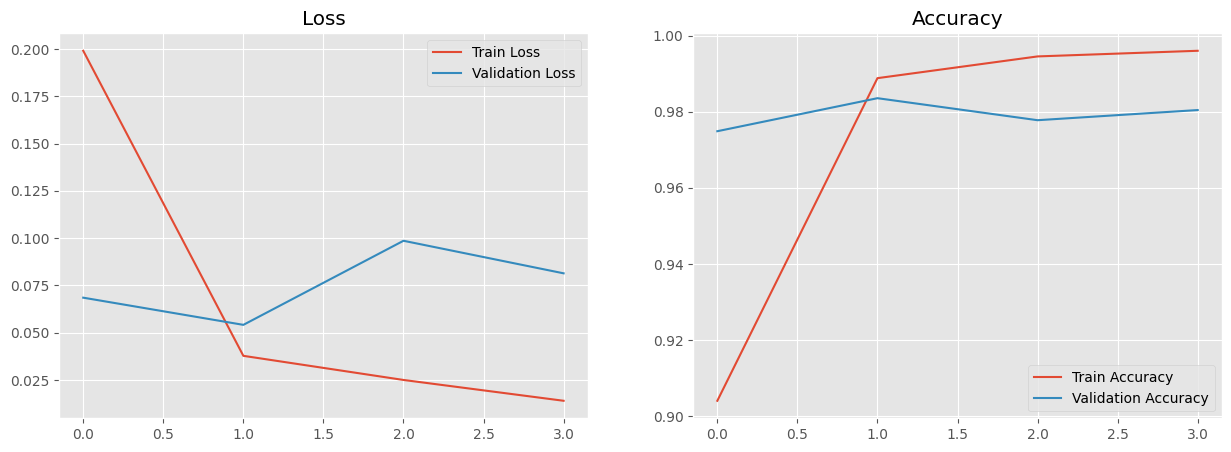

In [ ]:
draw_history(hist)

# Evaluation model

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
save_path=r'/content/model.h5'

from keras.models import load_model
model = load_model(save_path)

## Test Data


In [37]:
test_ds= pd.read_csv(PATH_EXTERNAL_DF4,encoding='utf-8',sep=',')

In [38]:
# Assuming 'text' is a Pandas DataFrame column
texts = test_ds['text']

# Initialize lists to store preprocessed tokens
tokens_processed = []
tokens_List=[]
tokens_before_pos=[]

for text in texts:
    # Tokenize the text
    tokens = word_tokenize(text)
    tokens_List.append(tokens)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Perform stemming and lemmatization
    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()

    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Remove digits and punctuation
    cleaned_tokens = [token for token in lemmatized_tokens if not token.isdigit() and not token in string.punctuation]

    # Convert all tokens to lowercase
    lowercase_tokens = [token.lower() for token in cleaned_tokens]
    tokens_before_pos.append(lowercase_tokens)

    # Perform part-of-speech (POS) tagging
    pos_tags = pos_tag(lowercase_tokens)
    # Perform named entity recognition (NER)
    named_entities = ne_chunk(pos_tags)

    # Append the preprocessed tokens for this text to the overall list
    tokens_processed.append(named_entities)

# Now 'tokens_processed' contains the preprocessed tokens for each text entry in your DataFrame.


### EDA on Test DataSet

#### 1.Number Of Examples

In [39]:
test_ds['label'].value_counts()

0    29792
1    14414
Name: label, dtype: int64

In [40]:
px.pie(test_ds,names='label',title=' Categories in test data')

#### 2.Histogram of Test Data

In [41]:
# text_lengths = [len(tokens) for tokens in tokens_List]
text_lengths = [len(tokens) for tokens in tokens_processed]
fig = ff.create_distplot([text_lengths], ['Text Length'],show_hist=True)
fig.show()


#### 3.Top 25 tokens frequencies By Label


In [42]:

token_UNgene_test=[]
for text in test_ds[test_ds['label']==0]['text']:
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    cleaned_tokens = [token for token in lemmatized_tokens if not token.isdigit() and not token in string.punctuation]
    lowercase_tokens = [token.lower() for token in cleaned_tokens]

    token_UNgene.append(lowercase_tokens)




d_UNg = dict()
for tbp in token_UNgene:
    for word in tbp:
        if word:
            if word in d_UNg:
                d_UNg[word] += 1
            else:
                d_UNg[word] = 1

df_unique_UNgene = pd.DataFrame(list(d_UNg.items()), columns=['Token', 'Frequency'])

# ==-=-=-=-=-====================-----============

token_gene_test=[]
for text in test_ds[test_ds['label']==1]['text']:

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    stemmer = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    cleaned_tokens = [token for token in lemmatized_tokens if not token.isdigit() and not token in string.punctuation]
    lowercase_tokens = [token.lower() for token in cleaned_tokens]

    token_gene.append(lowercase_tokens)



d_gene = dict()
for tbp in token_gene:
    for word in tbp:
        if word:
            if word in d_gene:
                d_gene[word] += 1
            else:
                d_gene[word] = 1


df_unique_gene = pd.DataFrame(list(d_gene.items()), columns=['Token', 'Frequency'])

# --==-===-=-=-=-==-=-=-==--=-=-=-=-=-=-=-=-=-=

df_unique_UNgene['label_str']='Ungenerated'
df_unique_gene['label_str']='generated'

df_uniqu_Classes_test = pd.concat([df_unique_gene, df_unique_UNgene])
df_uniqu_Classes_test.reset_index(inplace=True, drop=True)



In [43]:
top_25_all = df_uniqu_Classes.sort_values(by='Frequency', ascending=False)[:25]

fig = px.bar(top_25_all, x="Token", y="Frequency", color="label", title="Top 25 tokens frequencies By Label")
fig.show()

## Evaluation

In [ ]:
# Vectorize the data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


test_text = test_ds['text'].values
vectorized_test_text = vectorize_layer(test_text)

In [ ]:
predictions = model.predict(vectorized_test_text)
test_ds['generated'] = predictions

1382/1382 [==============================] - 28s 20ms/step


In [ ]:
import pandas as pd

# Assuming test_ds is your DataFrame
test_ds['generated'] = (test_ds['generated'] > 0.5).astype(int)


In [ ]:
test_ds[['text', 'label','generated']]

,text,label,generated
0,"In recent years, technology has had a profoun...",1,1
1,Should students participate in an extracurricu...,0,0
2,The electoral college is a symbol of mockery a...,0,0
3,This is why I think the principle should allow...,0,0
4,I strongly believe that meditation and mindful...,1,1
...,...,...,...
44201,"""Oh man I didn't make the soccer team!"", yelle...",0,0
44202,I believe that using this technology could be ...,0,0
44203,The Face on Mars is a fascinating phenomenon t...,1,1
44204,Texting & Driving\n\nUsing your phone while dr...,0,0


In [ ]:
score, acc= model.evaluate(vectorized_test_text,test_ds['label'])
print('Test Loss =', score)
print('Test Accuracy =', acc)

1382/1382 [==============================] - 29s 18ms/step - loss: 0.1073 - accuracy: 0.9735
Test Loss = 0.10734067857265472
Test Accuracy = 0.9734877347946167


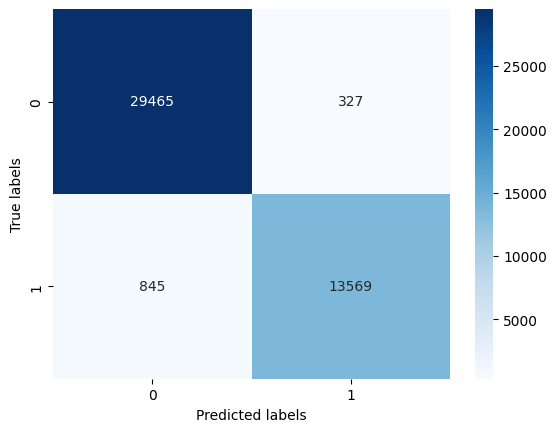

In [ ]:

# y_pred_classes = np.argmax(y_pred, axis=1)
confusion_Matrix = confusion_matrix(test_ds['label'],test_ds['generated'])
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues',fmt='.5g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
print(classification_report(test_ds['label'],test_ds['generated']))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29792
           1       0.98      0.94      0.96     14414

    accuracy                           0.97     44206
   macro avg       0.97      0.97      0.97     44206
weighted avg       0.97      0.97      0.97     44206



In [1]:
19986 > 44206

False